In [32]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
gene_exp_df = pd.read_table('data/trunc_combined_rna_data.tsv', header=0, index_col=0)

In [34]:
gene_exp_df.head()

,TCGA-A6-2671,TCGA-A6-2672,TCGA-A6-2674,TCGA-A6-2676,TCGA-A6-2677,TCGA-A6-2678,TCGA-A6-2679,TCGA-A6-2680,TCGA-A6-2681,TCGA-A6-2682,...,TCGA-EI-6885,TCGA-CI-6624,TCGA-AF-6655,TCGA-F5-6863,TCGA-3L-AA1B,TCGA-G4-6299,TCGA-EI-6883,TCGA-G5-6572,TCGA-CA-6719,TCGA-AY-6197
Hybridization REF,,,,,,,,,,,,,,,,,,,,,
?|100133144,31.7492,29.3631,19.5780,26.0449,0.5031,35.7625,0.0000,7.8027,22.0183,32.8947,...,12.6713,1.9447,9.2643,15.1487,18.0851,33.5487,11.1866,1.3166,12.4432,28.5650
?|100134869,25.5263,27.9618,13.6701,25.9032,14.3774,6.7667,0.0000,79.6413,0.0000,0.0000,...,6.4091,1.7419,10.5433,8.6431,15.7640,29.6906,0.0000,9.5880,5.6375,21.7212
?|10357,236.7337,828.1529,924.7059,624.3211,539.3129,662.1644,114.9147,200.3027,274.5780,264.1228,...,182.3647,161.8802,298.9078,392.7993,144.4004,159.6633,298.4898,225.4968,240.4543,226.0343
?|10431,1386.9969,1108.2803,1180.3069,1008.2645,1060.0607,1220.4360,880.5724,1242.1525,815.5963,1326.7544,...,621.8330,705.9908,840.9734,894.0520,774.6615,1190.6278,851.7779,776.2520,740.3802,721.1774
?|136542,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### We want to test the batching of the data we're using in particular for classification, therefore using the split of patients that was defined in combine_hiseq_ga_rna

In [3]:
hiseq_patient_list = []
with open('data/illumina_hiseq_patients.tsv', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t',)
    for row in csvreader:
        hiseq_patient_list += row

In [4]:
ga_patient_list = []
with open('data/illumina_ga_patients.tsv', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t',)
    for row in csvreader:
        ga_patient_list += row

In [5]:
print(len(hiseq_patient_list))
print(len(ga_patient_list))

359
263


In [6]:
data_logged = gene_exp_df.copy()
data_logged = np.log(data_logged)
data_logged.replace([np.inf, -np.inf], np.nan, inplace=True)
len(data_logged.columns.values)  # Number of patients

622

In [7]:
### Replace all NaNs with lowest possible values in matrix
a = list(data_logged.min())
lowest_possible_exp_value = math.floor(min(a))
# We want to replace all NaNs with a very small value.
# The smallest value is almost -5, therefore we can replace all NaNs with -5
# to ensure that an NaN represents the floor of the range.
data_logged.replace(np.nan, lowest_possible_exp_value, inplace=True)

In [8]:
data_logged.head()

,TCGA-A6-2671,TCGA-A6-2672,TCGA-A6-2674,TCGA-A6-2676,TCGA-A6-2677,TCGA-A6-2678,TCGA-A6-2679,TCGA-A6-2680,TCGA-A6-2681,TCGA-A6-2682,...,TCGA-EI-6885,TCGA-CI-6624,TCGA-AF-6655,TCGA-F5-6863,TCGA-3L-AA1B,TCGA-G4-6299,TCGA-EI-6883,TCGA-G5-6572,TCGA-CA-6719,TCGA-AY-6197
Hybridization REF,,,,,,,,,,,,,,,,,,,,,
?|100133144,3.457868,3.379739,2.974406,3.259822,-0.686966,3.576900,-6.000000,2.054470,3.091874,3.493312,...,2.539340,0.665108,2.226168,2.717915,2.895088,3.512998,2.414717,0.275053,2.521174,3.352182
?|100134869,3.239709,3.330839,2.615211,3.254367,2.665658,1.912014,-6.000000,4.377533,-6.000000,-6.000000,...,1.857719,0.554976,2.355491,2.156761,2.757729,3.390830,-6.000000,2.260512,1.729441,3.078289
?|10357,5.466936,6.719198,6.829476,6.436665,6.290296,6.495514,4.744190,5.299830,5.615235,5.576414,...,5.206009,5.086857,5.700135,5.973299,4.972590,5.073067,5.698736,5.418306,5.482530,5.420687
?|10431,7.234896,7.010565,7.073530,6.915986,6.966081,7.106963,6.780572,7.124601,6.703920,7.190491,...,6.432672,6.559602,6.734560,6.795764,6.652426,7.082236,6.747326,6.654477,6.607164,6.580885
?|136542,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,...,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000


In [9]:
pca = PCA()

In [10]:
len(reduced_data)

NameError: name 'reduced_data' is not defined

### Not Scaled Data

In [11]:
reduced_data = pca.fit_transform(data_logged.transpose())

In [29]:
def plot_pca_components(x_axis_pc, y_axis_pc):
    plt.figure(figsize=(6,6))
    
    for i, name in enumerate(data_logged.columns.tolist()):
        if name in hiseq_patient_list:
            color = 'blue'
            hiseq = plt.scatter(reduced_data[i,x_axis_pc], reduced_data[i,y_axis_pc],c=color)
        else:
            color = 'red'
            ga = plt.scatter(reduced_data[i,x_axis_pc], reduced_data[i,y_axis_pc],c=color)
        
    
#     plt.axvline()
#     plt.axhline()
    plt.xlabel('PC'+str(x_axis_pc+1)+ ' (%.3f variance explained)'%pca.explained_variance_ratio_[x_axis_pc])
    plt.ylabel('PC'+str(y_axis_pc+1)+ ' (%.3f variance explained)'%pca.explained_variance_ratio_[y_axis_pc])
    plt.legend([ga, hiseq], ['GA', 'Hiseq'])
    plt.show()

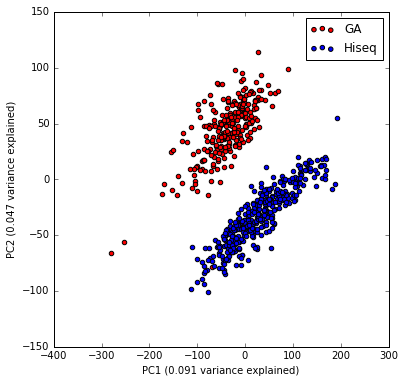

In [30]:
plot_pca_components(0, 1)

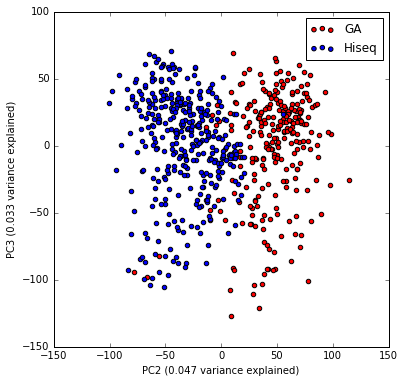

In [31]:
plot_pca_components(1, 2)

### Scaled Data

In [19]:
from sklearn.preprocessing import scale

reduced_data = pca.fit_transform(scale(data_logged.transpose()))

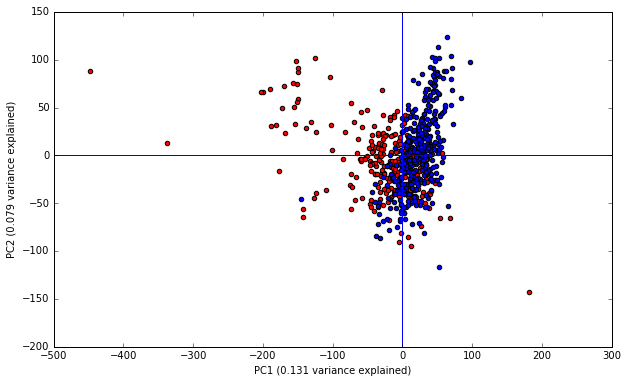

In [20]:
plot_pca_components(0, 1)

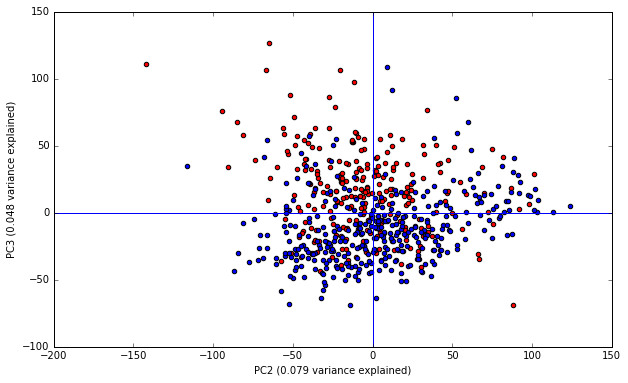

In [21]:
plot_pca_components(1, 2)